In [36]:
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt

speed = 0.343 # mm / us
radius_mm = 230/2

def functions(x0, y0, x1, y1, x2, y2, d01, d02, d12):
    """ Given observers at (x0, y0), (x1, y1), (x2, y2) and TDOA between observers d01, d02, d12, this closure
        returns a function that evaluates the system of three hyperbolae for given event x, y.
    """
    def fn(args):
        x, y = args
        a = np.sqrt(np.power(x - x1, 2.) + np.power(y - y1, 2.)) - np.sqrt(np.power(x - x0, 2.) + np.power(y - y0, 2.)) - d01
        b = np.sqrt(np.power(x - x2, 2.) + np.power(y - y2, 2.)) - np.sqrt(np.power(x - x0, 2.) + np.power(y - y0, 2.)) - d02
        c = np.sqrt(np.power(x - x2, 2.) + np.power(y - y2, 2.)) - np.sqrt(np.power(x - x1, 2.) + np.power(y - y1, 2.)) - d12
        return [a, b, c]
    return fn
def jacobian(x0, y0, x1, y1, x2, y2, d01, d02, d12):
    def fn(args):
        x, y = args
        adx = (x - x1) / np.sqrt(np.power(x - x1, 2.) + np.power(y - y1, 2.)) - (x - x0) / np.sqrt(np.power(x - x0, 2.) + np.power(y - y0, 2.))
        bdx = (x - x2) / np.sqrt(np.power(x - x2, 2.) + np.power(y - y2, 2.)) - (x - x0) / np.sqrt(np.power(x - x0, 2.) + np.power(y - y0, 2.))
        cdx = (x - x2) / np.sqrt(np.power(x - x2, 2.) + np.power(y - y2, 2.)) - (x - x1) / np.sqrt(np.power(x - x1, 2.) + np.power(y - y1, 2.))
        ady = (y - y1) / np.sqrt(np.power(x - x1, 2.) + np.power(y - y1, 2.)) - (y - y0) / np.sqrt(np.power(x - x0, 2.) + np.power(y - y0, 2.))
        bdy = (y - y2) / np.sqrt(np.power(x - x2, 2.) + np.power(y - y2, 2.)) - (y - y0) / np.sqrt(np.power(x - x0, 2.) + np.power(y - y0, 2.))
        cdy = (y - y2) / np.sqrt(np.power(x - x2, 2.) + np.power(y - y2, 2.)) - (y - y1) / np.sqrt(np.power(x - x1, 2.) + np.power(y - y1, 2.))

        return [
            [adx, ady],
            [bdx, bdy],
            [cdx, cdy]
        ]
    return fn

def solve_3_points(measurement0, measurement1, measurement2):
    x0, y0, t0 = measurement0
    x1, y1, t1 = measurement1
    x2, y2, t2 = measurement2
    xp = np.mean([x0, x1, x2])
    yp = np.mean([y0, y1, y2])
    F = functions(x0, y0, x1, y1, x2, y2, (t1 - t0) * speed, (t2 - t0) * speed, (t2 - t1) * speed)
    J = jacobian(x0, y0, x1, y1, x2, y2, (t1 - t0) * speed, (t2 - t0) * speed, (t2 - t1) * speed)
    [x, y], _ = opt.leastsq(F, x0=[xp, yp], Dfun=J)
    return x, y

def check_sol_validity(measurement0, measurement1, measurement2):
    solx, soly = solve_3_points(measurement0, measurement1, measurement2)
    valid = False
    if (solx ** 2 + soly ** 2 < radius_mm ** 2):
        valid = True
    return [solx, soly, measurement0, measurement1, measurement2,  valid]

def solve_best_fit(measurements):
    sols = []
    sols.append(check_sol_validity(measurements[0], measurements[1], measurements[2]))
    sols.append(check_sol_validity(measurements[0], measurements[1], measurements[3]))
    sols.append(check_sol_validity(measurements[0], measurements[1], measurements[4]))
    sols.append(check_sol_validity(measurements[0], measurements[2], measurements[3]))
    sols.append(check_sol_validity(measurements[0], measurements[2], measurements[4]))
    sols.append(check_sol_validity(measurements[0], measurements[3], measurements[4]))
    sols.append(check_sol_validity(measurements[1], measurements[2], measurements[3]))
    sols.append(check_sol_validity(measurements[1], measurements[2], measurements[4]))
    sols.append(check_sol_validity(measurements[1], measurements[3], measurements[4]))
    sols.append(check_sol_validity(measurements[2], measurements[3], measurements[4]))

    validx = [sol[0] for sol in sols if sol[-1]]
    validy = [sol[1] for sol in sols if sol[-1]]
    ret_data = [sol[:-1] for sol in sols if sol[-1]]

    meanx = np.mean(validx)
    meany = np.mean(validy)
    print("Means: ", meanx, meany)
    valid_pos = [(x,y) for x,y in zip(validx, validy)]
    print("Valid positions: ", valid_pos)
    print("Std: ", np.std(validx), np.std(validy))
    print("")
    return ret_data


In [11]:
import serial

# print available serial ports
import serial.tools.list_ports
print("Available serial ports:")
ports = serial.tools.list_ports.comports()
for port in ports:
    print(port.device)


Available serial ports:
/dev/cu.Bluetooth-Incoming-Port
/dev/cu.usbserial-1120


In [26]:
ser = serial.Serial('/dev/cu.usbserial-1120', 500000)

In [82]:
# read time_data from serial port till a new line
import time
import struct

while True:
    time_data = ser.readline()
    time_data = time_data.decode('utf-8')
    time_data = time_data.split(',')
    # remove trailing \n on last element
    time_data[-1] = time_data[-1].strip()
    time_data = [int(x) for x in time_data]

    coupled_measurements = [[radius_mm*np.cos(-i*np.pi/3), radius_mm*np.sin(-i*np.pi/3), time_data[i]] for i in range(len(time_data))]
    ret_data = solve_best_fit(coupled_measurements)

    


Means:  6.859205309219497 -4.321154074102181
Valid positions:  [(7.036480081067153, 3.2185910913734572), (9.947685147764698, 1.3447318334853284), (15.813079436234121, -2.424090397678116), (9.948867690696105, -2.2202861401380622), (1.4760000794318231e-12, -8.570627825031256e-13), (10.023476620017714, -14.234217115750111), (6.668141482711224, -3.902539162716981), (6.472028545906221, -7.750487750702274), (3.0516096443180127, -9.726115229102085), (-0.3693155565217533, -7.517127869792112)]
Std:  4.725304538966729 5.150409011385202

Means:  6.718532542870018 -4.327331598103088
Valid positions:  [(6.713768795532174, 3.8235103386982288), (9.948133556781398, 1.7296972594216966), (16.114058977351142, -2.254124199455891), (9.948867690696105, -2.2202861401380622), (1.469638751055982e-12, -8.681769437790338e-13), (10.028515692753782, -14.6975396337455), (6.325365920475113, -4.0784005888566535), (6.1384145029582795, -7.942582130070717), (2.699058683160631, -9.930524837769045), (-0.7308583910099044, 

KeyboardInterrupt: 

In [83]:
ret_data[0]

[5.136475959207072,
 -29.639914965294167,
 [115.0, 0.0, 8193],
 [57.500000000000014, -99.59292143521044, 8116],
 [-57.49999999999998, -99.59292143521046, 8135]]

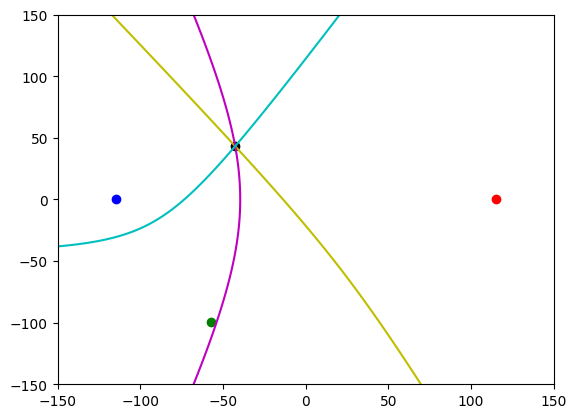

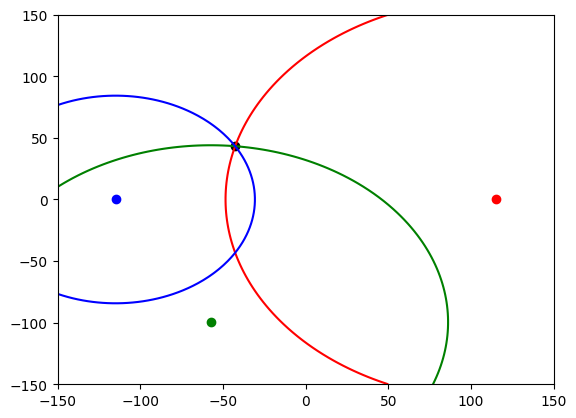

In [86]:
index = 3
measurements = ret_data[index]
x0, y0, t0 = measurements[2]
x1, y1, t1 = measurements[3]
x2, y2, t2 = measurements[4]
x = measurements[0]
y = measurements[1]

# Create reasonable x, y bounds for visualization
max_x = max(x0, x1, x2, x)
min_x = min(x0, x1, x2, x)
range_x = max_x - min_x
min_x -= range_x * .2
max_x += range_x * .2

max_y = max(y0, y1, y2, y)
min_y = min(y0, y1, y2, y)
range_y = max_y - min_y
min_y -= range_y * .2
max_y += range_y * .2

max_x = 150
min_x = -150
min_y = -150
max_y = 150

# Create a grid of input coordinates
xs = np.linspace(min_x, max_x, 100)
ys = np.linspace(min_y, max_y, 100)
xs, ys = np.meshgrid(xs, ys)

# Evaluate the system across the grid
F = functions(x0, y0, x1, y1, x2, y2, (t1 - t0) * speed, (t2 - t0) * speed, (t2 - t1) * speed)
A, B, C = F((xs, ys))

# Plot the results
plt.scatter(x0, y0, color='r')
plt.scatter(x1, y1, color='g')
plt.scatter(x2, y2, color='b')
plt.scatter(x, y, color='k')
plt.contour(xs, ys, A, [0], colors='y')
plt.contour(xs, ys, B, [0], colors='m')
plt.contour(xs, ys, C, [0], colors='c')
plt.show()

d0 = np.sqrt(np.power(x - x0, 2.) + np.power(y - y0, 2.))
d1 = np.sqrt(np.power(x - x1, 2.) + np.power(y - y1, 2.))
d2 = np.sqrt(np.power(x - x2, 2.) + np.power(y - y2, 2.))
t0 = d0 / speed
t1 = d1 / speed
t2 = d2 / speed

def circle(cx, cy, r):
    def fn(x, y):
        return np.sqrt(np.power(x - cx, 2.) + np.power(y - cy, 2.)) - r
    return fn

c0 = circle(x0, y0, d0)
c1 = circle(x1, y1, d1)
c2 = circle(x2, y2, d2)

plt.scatter(x0, y0, color='r')
plt.scatter(x1, y1, color='g')
plt.scatter(x2, y2, color='b')
plt.scatter(x, y, color='k')

plt.contour(xs, ys, c0(xs, ys), [0], colors='r')
plt.contour(xs, ys, c1(xs, ys), [0], colors='g')
plt.contour(xs, ys, c2(xs, ys), [0], colors='b')
plt.show()

5
[[115.0, 0.0], [57.500000000000014, -99.59292143521044], [-57.49999999999998, -99.59292143521046], [-115.0, -1.4083438190194563e-14], [-57.50000000000005, 99.59292143521041]]


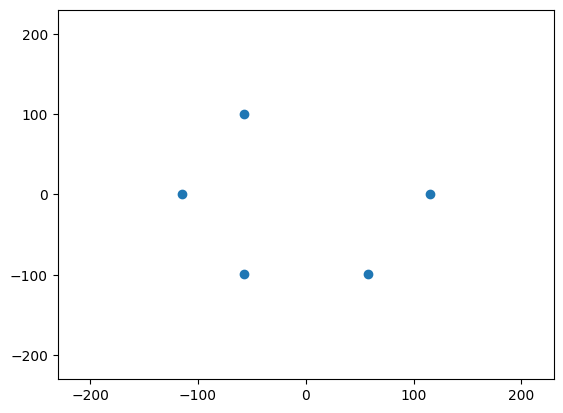

In [80]:
positions = [x[0:2] for x in coupled_measurements]
print(len(positions))
print(positions)

# plot the positions
plt.xlim([-radius_mm*2, radius_mm*2])
plt.ylim([-radius_mm*2, radius_mm*2])
plt.scatter([x[0] for x in positions], [x[1] for x in positions])


In [10]:
ser.close()

Means:  6.859205309219497 -4.321154074102181
Valid positions:  [(7.036480081067153, 3.2185910913734572), (9.947685147764698, 1.3447318334853284), (15.813079436234121, -2.424090397678116), (9.948867690696105, -2.2202861401380622), (1.4760000794318231e-12, -8.570627825031256e-13), (10.023476620017714, -14.234217115750111), (6.668141482711224, -3.902539162716981), (6.472028545906221, -7.750487750702274), (3.0516096443180127, -9.726115229102085), (-0.3693155565217533, -7.517127869792112)]
Std:  4.725304538966729 5.150409011385202

Means:  6.718532542870018 -4.327331598103088
Valid positions:  [(6.713768795532174, 3.8235103386982288), (9.948133556781398, 1.7296972594216966), (16.114058977351142, -2.254124199455891), (9.948867690696105, -2.2202861401380622), (1.469638751055982e-12, -8.681769437790338e-13), (10.028515692753782, -14.6975396337455), (6.325365920475113, -4.0784005888566535), (6.1384145029582795, -7.942582130070717), (2.699058683160631, -9.930524837769045), (-0.7308583910099044, -7.703066049114069)]
Std:  4.872132057535123 5.422656419346677

Means:  -14.356871967592156 19.754334948816176
Valid positions:  [(26.618705573266777, 5.841528936978631), (6.716610416993397e-13, 1.5520226885336668e-12), (29.99606120353984, 58.49353628374796), (-49.9383790225302, -33.64076779335151), (-82.61843479876397, 27.299601320366303), (-10.199184761066043, 60.53211094515413)]
Std:  40.40476740795495 33.30495633068539

Means:  60.21414031401387 -19.85959248384517
Valid positions:  [(87.19511443792202, -3.3480847782761156), (91.40837481751329, -8.032455063899421), (1.693786109369914e-12, -1.404552797676744e-13), (41.09120321588657, -76.71876809514427), (81.37600909874574, -11.198654481905894)]
Std:  35.0437079613759 28.68760072977776

Means:  43.23185764196265 32.91664115233213
Valid positions:  [(57.77104833433422, 47.48956950356836), (59.703146370313554, 43.40131405920573), (1.4987676924595647e-12, 7.871876818299653e-13), (55.453235863201336, 40.77568104655367)]
Std:  25.005234547806214 19.15442755281865

Means:  -4.888391914983339e-13 1.6250698550488006e-12
Valid positions:  [(-4.888391914983339e-13, 1.6250698550488006e-12)]
Std:  0.0 0.0

Means:  49.41005611701056 -4.495557721352424
Valid positions:  [(59.89026877973979, 55.27333108114336), (95.3439666525836, -8.797157536933529), (81.00750107251919, 10.258819632339453), (1.6912875799250816e-12, -1.7055247679449617e-13), (21.724370601569973, -74.64752302480592), (38.49422959564911, -9.060816479857735)]
Std:  33.02817892561027 38.23363559190762

Means:  1.463194269237209e-12 -8.792430963922813e-13
Valid positions:  [(1.463194269237209e-12, -8.792430963922813e-13)]
Std:  0.0 0.0

Means:  57.68903331095881 -15.969936297655712
Valid positions:  [(78.40543244117903, -20.552020518141735), (57.193030239081665, -1.9650448193877355), (1.6760469811824182e-12, 2.6156382429865846e-13), (42.5822202320896, -76.89090206614873), (110.26448364244207, 19.558285915399363)]
Std:  36.74189313380784 33.002393823051676

Means:  -1.5910989390064636 -14.887548555719148
Valid positions:  [(5.136475959207072, -29.639914965294167), (-17.639286218189913, -21.967697127510558), (-1.2933768779011216e-12, -1.1405436103839546e-12), (6.1384145029582795, -7.942582130070717)]
Std:  9.55355369538 11.59345159058814

Means:  20.681980678154343 -25.9854037736556
Valid positions:  [(0.3659961308312775, 7.939904994307769), (7.714519321409748e-13, 1.504731923953308e-12), (61.67994590363097, -85.89611631527607)]
Std:  28.99032427970856 42.48710102892534

Means:  33.60282745047017 -16.151754154242003
Valid positions:  [(68.97426662572012, -35.79376903170822), (31.83421572568877, -12.661493431018243), (1.6302360743899643e-12, 4.636840235386135e-13)]
Std:  28.18638388434744 14.819692199027747

Means:  1.659054394541081e-12 -3.789650800640224e-13
Valid positions:  [(1.659054394541081e-12, -3.789650800640224e-13)]
Std:  0.0 0.0

Means:  40.603504999752815 -14.81662022946437
Valid positions:  [(55.31253525029146, -49.10396843739025), (2.8996753674012727, -29.19933450630499), (1.533942284241941e-12, 7.171569033932662e-13), (104.201809381317, 19.036822025837058)]
Std:  42.81157343035749 26.211030620036745

Means:  10.494943169514963 15.052255035250491
Valid positions:  [(103.89405757054807, 35.097812974412555), (1.533942284241941e-12, 7.171569033932662e-13), (-72.40922806200471, 10.058952131338206)]
Std:  72.35707754051828 14.757233803897943

Means:  15.444088097438161 -24.135897957077233
Valid positions:  [(55.13287762884379, -48.81368675683935), (10.314729573422836, -31.439639996944166), (23.492573081006515, -36.15361715396793), (10.689452500014669, 45.08446144719013), (1.659054394541081e-12, -3.789650800640224e-13), (11.807425085682247, -73.2748480983963), (80.60534417007756, -11.452080546940284), (-4.615043933472969, -54.4573692918732), (-48.43056522863282, -6.7163012159236395)]
Std:  34.43023475389831 33.29850318356379

Means:  -18.68354063674697 -3.872443570013002
Valid positions:  [(-6.718884749195801, -28.799164381377206), (-19.423371932190943, -24.90956341392014), (7.415388494857671e-13, 1.5197422640182804e-12), (-6.5201164291070395, -3.5511665395189143), (4.507384448112747, -10.666782825566788), (-83.94625515810151, 44.69201574030352)]
Std:  30.104719544230466 24.09588697229891

Means:  -54.89280889568108 -13.155042635015214
Valid positions:  [(1.1347367744731056e-12, -1.2822070101952336e-12), (-109.7856177913633, -26.310085270029145)]
Std:  54.892808895682215 13.155042635013931

Means:  29.095570336048848 -28.20531497975488
Valid positions:  [(32.055712893628, -42.128280713983976), (68.94942852877432, -57.579484827560535), (1.5632657618541634, -32.05449657957632), (1.4760000794318231e-12, -8.570627825031256e-13), (42.909444495986286, -9.264312777652712)]
Std:  26.04801560372594 21.098854876982458

Means:  2.51460996934227 9.0684189521501
Valid positions:  [(-33.551928856782, 98.53526314064356), (71.00657109518117, -14.537499460831821), (-27.396202361030245, -47.724087871209626), (1.5128101993147826e-13, -1.714560871562053e-12)]
Std:  41.51181735157001 54.47288464626606

Means:  11.135602756210798 -9.292513203032009
Valid positions:  [(7.036480081067153, 3.2185910913734572), (32.00464739486917, -12.769843600926082), (1.1406766709886002e-12, -1.2768216347688143e-12), (5.501283548905723, -27.61880030257413)]
Std:  12.329507619022175 12.153427066520717

Means:  19.21372927495307 -17.652892302112736
Valid positions:  [(30.031770086774586, -38.58394919967352), (29.000530473860003, -38.195871390789776), (-39.55971024390951, -14.834195336341834), (28.871588732600777, -36.54203909380994), (-4.774819103911676e-13, 1.6283483771653281e-12), (30.698690012144784, -36.18987214072936), (55.453235863201336, 40.77568104655367)]
Std:  28.220500351036517 27.500676520295947

Means:  31.537659535614274 -28.081337818139346
Valid positions:  [(30.031770086774586, -38.58394919967352), (49.01766062526154, -46.15176305819178), (3.2446060929825014, -28.988475591056318), (57.683402457495085, -85.21788018412273), (1.469638751055982e-12, -8.681769437790338e-13), (52.31443884631041, 63.12043554341168), (21.226965929426626, -79.51580756553494), (38.78243224666199, -9.313262489946311)]
Std:  20.5457129012232 44.449863349530304

Means:  17.491239489778046 -2.3111256472071817
Valid positions:  [(1.4696387510559811e-12, -8.681769437790353e-13), (91.1175767447395, 57.15826903931823), (-29.902965171097506, -102.76201303777158), (-55.17220765998266, -23.159184444222376), (81.41379353522944, 57.20730020664069)]
Std:  58.888133098760605 59.34545569024566

Means:  -12.242194421670714 -23.266028550135076
Valid positions:  [(1.0256139383970412e-12, -1.3727488502747392e-12), (61.934426185240895, 7.7058173508474095), (-48.37476142961789, -98.90697729252564), (-96.84123388219834, -45.63891331284716), (22.07059701822074, 20.5099305038514)]
Std:  55.30274839742579 43.9067125013037

Means:  18.813249898198645 -47.78677130295915
Valid positions:  [(4.985121211644563, -33.12544474376131), (67.00773356511327, -56.60444966086301), (6.168710060331685e-13, -1.603148984357897e-12), (3.2601448160361337, -101.4171908072107)]
Std:  27.882623837801013 36.92053410997076

Means:  -9.473903143468002e-15 -1.4210854715202004e-14
Valid positions:  [(-9.473903143468002e-15, -1.4210854715202004e-14)]
Std:  0.0 0.0

Means:  27.214615193623434 8.986229661579754
Valid positions:  [(82.01316113739037, 34.475816854531516), (1.693786109369914e-12, -1.404552797676744e-13), (-0.3693155565217533, -7.517127869792112)]
Std:  38.748716767211995 18.28325452981532

Means:  46.04916923265548 17.363975000997396
Valid positions:  [(78.44436132765331, 8.690610943788124), (59.703146370313554, 43.40131405920573), (-4.2637881797045156e-13, -1.6704785314743129e-12)]
Std:  33.44849547969377 18.74991464101736

Means:  7.617481780947863e-13 1.5096818011154025e-12
Valid positions:  [(7.617481780947863e-13, 1.5096818011154025e-12)]
Std:  0.0 0.0

Means:  -12.253943525232856 -32.1810719152102
Valid positions:  [(-22.914186078757744, -20.233432170573323), (28.061944880222544, -37.84430074819361), (-39.55971024390951, -14.834195336341834), (-1.665975928796511e-12, -4.301836472044269e-13), (-13.587362445103876, -113.14823857952078), (-25.524347263846888, -7.026264656631204)]
Std:  21.65124045190464 38.07842822999058

Means:  -5.01422609543315 -21.249102660658483
Valid positions:  [(104.24561133911564, 19.053648244944092), (9.948867690696105, -2.2202861401380622), (9.54343966267724e-13, -1.4242064006966729e-12), (-80.67754855648765, -50.35358164933463), (-58.5880609504908, -72.72529375876239)]
Std:  64.46990439287957 34.45228845747297

Means:  35.446099937146585 -42.61717992491736
Valid positions:  [(90.40729227801704, -68.03770088124678), (-18.056924659665974, -22.21984172065146), (7.358081067936607e-13, 1.522534749068323e-12), (69.43403213023451, -80.21117709777272)]
Std:  45.538203302428826 32.755865656764264

Means:  -20.923584214954996 9.234328172071391
Valid positions:  [(10.711981633256757, 51.34262102170447), (1.483522423303338e-12, -8.436650694252478e-13), (-73.48273427812323, -23.63963650548945)]
Std:  37.42133820117232 31.300046310516883

Means:  41.1148535192329 -15.516201567445805
Valid positions:  [(85.75433171222609, -45.74425484698255), (0.022778182060706136, 7.740798018739885), (78.68230418264405, -24.06134944154206), (7.674460000184223e-13, 1.5067848024629631e-12)]
Std:  41.17944328823028 21.026146211884498

Means:  49.353280991781716 0.015512131024336165
Valid positions:  [(65.41224622928513, -33.631803922475456), (43.81503046911, -20.240667990137347), (32.00464739486917, -12.769843600926082), (43.46422648081694, 14.89229191653356), (1.6484591469634304e-12, 3.960211850466256e-13), (43.395313642933985, 13.603141763728834), (104.201809381317, 19.036822025837058), (70.00230460232355, 5.161958275025645), (41.88395072537805, 14.087710711632415)]
Std:  27.051384213592833 17.314686891209302

Means:  29.566639099385995 -27.695582280892037
Valid positions:  [(15.813079436234121, -2.424090397678116), (1.150975475841299e-12, 1.2389409971757747e-12), (72.88683786192271, -80.66265644499923)]
Std:  31.30487806432537 37.46644954883906

Means:  -4.780667783669317 -31.447402121956543
Valid positions:  [(55.002477204321984, -78.37962566098876), (1.0058474116692616e-12, -1.3875844210731933e-12), (-86.36679777671016, 26.365997385740297), (12.241649437709897, -73.77598021257631)]
Std:  51.3393978829603 45.62255580397677

Means:  64.06989166850337 -33.13220284284305
Valid positions:  [(94.19868531486561, -50.39412344399287), (1.6283944622669492e-12, -4.983797742791523e-13), (92.64684922891172, -1.9235108296061103), (69.43403213023451, -80.21117709777272)]
Std:  38.269151190290295 33.86048228441628

Means:  -1.0514645740200774 -9.637340080864865
Valid positions:  [(10.767721108053191, 47.49111597322047), (30.406013777057606, 25.715724997353284), (10.491604580153737, -38.42742588891291), (1.2885113251843295e-13, -1.7165323606573238e-12), (10.023476620017714, -14.234217115750111), (-41.54246808823581, -51.990072767103094), (-55.17220765998266, -23.159184444222376), (-12.699960483439341, 0.4248994262782162), (38.26263898019473, -32.55690090864555)]
Std:  29.128319234960596 29.924957102182915

Means:  8.311362031430485e-13 1.472532893982902e-12
Valid positions:  [(8.311362031430485e-13, 1.472532893982902e-12)]
Std:  0.0 0.0

Means:  6.166548936887661 -9.498244594195999
Valid positions:  [(27.289794484544885, 29.112578189037453), (30.406013777057606, 25.715724997353284), (31.81960212583385, -75.20813320689075), (1.3715808003576106e-13, -1.7158369554179522e-12), (26.78756437914143, 18.96776784010246), (-33.95886714448983, -72.16742143718118), (-54.85936506527081, -22.989530620516415), (21.847648938284028, 20.58305748452887)]
Std:  31.094981493273874 40.25460303763282

Means:  20.153441874895716 -4.6333738686530666
Valid positions:  [(7.036480081067153, 3.2185910913734572), (86.05258015028542, -45.917346737428986), (0.1846577782608716, 7.636311105088214), (3.2400738900137725e-13, 1.6608481152537138e-12), (7.493491364864805, 11.895575197700325)]
Std:  33.105706507364935 21.029689724591755

Means:  -3.514205591216983 16.364697999969966
Valid positions:  [(18.567366319159447, 38.74692693096427), (3.2400738900137725e-13, 1.6608481152537138e-12), (-29.10998309281072, 10.347167068943964)]
Std:  19.622175252178 16.38066127130261

Means:  6.859205309219497 -4.321154074102181
Valid positions:  [(7.036480081067153, 3.2185910913734572), (9.947685147764698, 1.3447318334853284), (15.813079436234121, -2.424090397678116), (9.948867690696105, -2.2202861401380622), (1.4760000794318231e-12, -8.570627825031256e-13), (10.023476620017714, -14.234217115750111), (6.668141482711224, -3.902539162716981), (6.472028545906221, -7.750487750702274), (3.0516096443180127, -9.726115229102085), (-0.3693155565217533, -7.517127869792112)]
Std:  4.725304538966729 5.150409011385202

Means:  1.697633404278268e-12 -6.728595274833605e-14
Valid positions:  [(1.697633404278268e-12, -6.728595274833605e-14)]
Std:  0.0 0.0

Means:  4.959794019693288 28.081066692286626
Valid positions:  [(1.5449562826000634e-12, 6.934466349881448e-13), (9.919588039385031, 56.162133384572556)]
Std:  4.959794019691744 28.081066692285933

Means:  10.580972025500333 -26.231712767286837
Valid positions:  [(5.136475959207072, -29.639914965294167), (10.314729573422836, -31.439639996944166), (3.032786613043486, -28.91572808119642), (10.491604580153737, -38.42742588891291), (1.2885113251843295e-13, -1.7165323606573238e-12), (10.023476620017714, -14.234217115750111), (4.708107534108657, -39.722326737582016), (5.227245842587954, -27.58314228372666), (18.612654552267013, -19.797831694814683), (38.26263898019473, -32.55690090864555)]
Std:  10.45418487080211 11.366381215355801

Means:  40.603504999752815 -14.81662022946437
Valid positions:  [(55.31253525029146, -49.10396843739025), (2.8996753674012727, -29.19933450630499), (1.533942284241941e-12, 7.171569033932662e-13), (104.201809381317, 19.036822025837058)]
Std:  42.81157343035749 26.211030620036745

Means:  3.2400738900137725e-13 1.6608481152537138e-12
Valid positions:  [(3.2400738900137725e-13, 1.6608481152537138e-12)]
Std:  0.0 0.0

Means:  25.526843253734086 10.237896558360362
Valid positions:  [(65.2008517161007, -33.28175210674863), (26.669224458531392, -9.045148844513298), (15.950258073933545, -2.1484357054899768), (30.53076530171426, 63.204753246581305), (1.2798116262468658e-12, 1.1059566099027481e-12), (26.976018400918715, 19.323014553498705), (44.69458546396639, 13.65799222816066), (-5.806957385293623, 30.19274909539302)]
Std:  21.49131057220966 26.976730443605007

Means:  5.33833160677058 -23.141370371201333
Valid positions:  [(-33.142290720128706, 29.228709983216657), (68.0546469200613, -35.237123112264236), (6.510840984829543e-13, -1.5892332201345718e-12), (-13.55902977285093, -86.55706835575616)]
Std:  38.07788909786562 43.145122332154884

Means:  11.493890665460668 7.58207713372246
Valid positions:  [(6.694681476996826, 3.4387272809354594), (9.947685147764698, 1.3447318334853284), (0.1846577782608716, 7.636311105088214), (9.94961612400066, -2.627809032962461), (3.132949396772953e-13, 1.6629452498821199e-12), (10.17093370740272, 24.44704937374373), (6.30562169005728, -4.484474957740601), (7.106405096574285, 11.668981378511825), (22.07059701822074, 20.5099305038514), (42.508708615328295, 13.887323852310045)]
Std:  11.87232178114546 9.334997151577268

Means:  0.8487944214353889 -0.15940833587606829
Valid positions:  [(-33.2811295543463, 29.869959616789796), (62.72000571557008, -31.761609723318465), (0.3659961308312775, 7.939904994307769), (-1.3005492744265194e-12, -1.1323149244467495e-12), (-25.560900184876814, -6.845296567158309)]
Std:  33.73818019085809 20.053864769905577

Means:  4.251957021625434 12.281845449497947
Valid positions:  [(75.62022854575476, -18.354221160663226), (10.767721108053191, 47.49111597322047), (30.406013777057606, 25.715724997353284), (1.1547086002626699e-12, 1.235473675014976e-12), (10.023476620017714, -14.234217115750111), (-12.699960483439341, 0.4248994262782162), (-84.35378041606705, 44.929616026045764)]
Std:  44.7367759195024 25.125797278287262

Means:  11.540480499636669 7.701707451402148
Valid positions:  [(7.036480081067153, 3.2185910913734572), (9.947685147764698, 1.3447318334853284), (0.1846577782608716, 7.636311105088214), (9.948867690696105, -2.2202861401380622), (3.2400738900137725e-13, 1.6608481152537138e-12), (10.17093370740272, 24.44704937374373), (6.668141482711224, -3.902539162716981), (7.493491364864805, 11.895575197700325), (22.07059701822074, 20.5099305038514), (41.88395072537805, 14.087710711632415)]
Std:  11.66660470823945 9.250735971455512

Means:  -2.8000451348279647 -0.7199696180372466
Valid positions:  [(-33.142290720128706, 29.228709983216657), (9.776288080293346, 1.4549986463300593), (0.022778182060706136, 7.740798018739885), (10.302086890171418, -38.11315430742737), (-1.3147871275632242e-12, -1.1156597692086605e-12), (9.996555032972783, 24.505311291146793), (-18.44257243222714, -45.034151111710685), (-25.560900184876814, -6.845296567158309), (21.847648938284028, 20.58305748452887)]
Std:  17.639278940818123 24.638288125162262

Means:  23.43820175147388 -31.67033238783846
Valid positions:  [(1.6980662575632259e-12, -5.080217414580554e-14), (46.87640350294606, -63.34066477567687)]
Std:  23.43820175147218 31.67033238783841

Means:  7.330397015802242 -1.7389967642519475
Valid positions:  [(7.036480081067153, 3.2185910913734572), (15.813079436234121, -2.424090397678116), (1.4760000794318231e-12, -8.570627825031256e-13), (6.472028545906221, -7.750487750702274)]
Std:  5.623917785890022 4.0065310512666334

Means:  10.5119741598242 0.10637583663821341
Valid positions:  [(63.102228157660726, 24.28705798329043), (1.6312981554913545e-12, -4.884464255944482e-13), (-31.56630567818976, -23.967930473375304)]
Std:  39.356566798184815 19.700160144902394

Means:  -8.474345272484099 44.01083753015002
Valid positions:  [(-7.586157711326453, 68.41175150285937), (-4.537612189949872, 64.91005603162108), (-6.726822337078312, 29.368662946393904), (-6.409575404082348e-13, 1.5726920222595605e-12), (-7.361229133399814, 60.30437715279233), (-28.97975930484472, 9.727551165961234), (-36.41347333456417, 44.2170985398806), (-10.199184761066043, 60.53211094515413), (25.535131319873134, 58.62592948668592)]
Std:  16.5095278454202 23.830298460482695

Means:  -6.409575404082348e-13 1.5726920222595605e-12
Valid positions:  [(-6.409575404082348e-13, 1.5726920222595605e-12)]
Std:  0.0 0.0

Means:  -4.294570070998721 33.76474099464234
Valid positions:  [(10.767721108053191, 47.49111597322047), (-4.537612189949872, 64.91005603162108), (9.948867690696105, -2.2202861401380622), (-6.409575404082348e-13, 1.5726920222595605e-12), (13.27318757512612, 101.22347870715915), (-23.100681346351777, -19.268276149248475), (-36.41347333456417, 44.2170985398806)]
Std:  17.493551519134662 39.759738987600976

Means:  1.0132843270356333 -1.5050585019171465
Valid positions:  [(59.56549486653362, -4.231513916940264), (-4.537612189949872, 64.91005603162108), (-6.409575404082348e-13, 1.5726920222595605e-12), (-13.547987706840766, -112.42093316414872), (-36.41347333456417, 44.2170985398806)]
Std:  31.852765621327354 61.34087233708042

Means:  -4.312130283825209 33.89339819725921
Valid positions:  [(10.767721108053191, 47.49111597322047), (-4.656245910785037, 65.046151093078), (9.948867690696105, -2.2202861401380622), (-6.419325527683567e-13, 1.5723036840138263e-12), (13.30718374963166, 101.81390425719277), (-23.100681346351777, -19.268276149248475), (-36.45175727801996, 44.39117834670817)]
Std:  17.5087584847639 39.92477700145156

Means:  38.39854895952568 5.64691798172301
Valid positions:  [(76.79709791905043, 11.293835963447465), (9.207285897229916e-13, -1.4466059284811449e-12)]
Std:  38.39854895952475 5.646917981724456

Means:  13.410179743681349 14.434766056223868
Valid positions:  [(79.35845362579839, -21.28494968957774), (7.002489164503245, 51.74783486334874), (-4.774819103911676e-13, 1.6283483771653281e-12), (-32.72022381557576, 27.27617905112284)]
Std:  40.92090046628673 27.574569604843923

Means:  -26.865635740611964 11.571072999534225
Valid positions:  [(-78.97990760619544, -29.714204766273635), (-1.7032716907559376e-12, 2.0506381268398384e-13), (-84.00087785158603, 44.72387717543938), (8.741660005249125, 43.31642069484909), (7.116793057248487, 11.87487965040062), (-12.699960483439341, 0.4248994262782162), (-28.23715730555885, 10.371638816045703)]
Std:  36.5030879537929 24.1158144370914

Means:  1.0132843270356333 -1.5050585019171465
Valid positions:  [(59.56549486653362, -4.231513916940264), (-4.537612189949872, 64.91005603162108), (-6.409575404082348e-13, 1.5726920222595605e-12), (-13.547987706840766, -112.42093316414872), (-36.41347333456417, 44.2170985398806)]
Std:  31.852765621327354 61.34087233708042

Means:  6.587227192697145 -0.1490958261752456
Valid positions:  [(6.713768795532174, 3.8235103386982288), (9.948133556781398, 1.7296972594216966), (9.948867690696105, -2.2202861401380622), (9.33944449583745e-13, -1.4379362976364814e-12), (6.325365920475113, -4.0784005888566535)]
Std:  3.6351744006928453 2.7951013577236963

Means:  22.611340240276135 -11.775527325218548
Valid positions:  [(59.56549486653362, -4.231513916940264), (42.718151188253884, 12.596727107747832), (1.1423912420628105e-12, -1.2752576470043838e-12), (69.03786040432205, 57.86849076972342), (-13.547987706840766, -112.42093316414872), (-22.10547731061314, -24.46593474769228)]
Std:  35.9251041337154 51.52736389802414

Means:  57.96984811973623 -6.913405156739844
Valid positions:  [(65.0947828383822, -33.43836651514108), (62.55702234523295, -31.887820506342084), (31.83421572568877, -12.661493431018243), (61.85078586127227, -27.8674433589507), (1.6479846638924526e-12, 3.979340514078143e-13), (69.03786040432205, 57.86849076972342), (70.01269777204415, -26.28641070900785), (103.37142001094583, 18.96580249681738)]
Std:  28.41495417339278 29.767732481036067

Means:  57.93627738082709 -7.040580535179085
Valid positions:  [(65.0947828383822, -33.43836651514108), (62.55702234523295, -31.887820506342084), (32.00464739486917, -12.769843600926082), (61.85078586127227, -27.8674433589507), (1.649867479623377e-12, 3.9028698275903353e-13), (68.86767148354399, 57.311328427397136), (70.01269777204415, -26.28641070900785), (103.10261135127037, 18.613911981537598)]
Std:  28.333534818205965 29.580618730757106

Means:  6.757861039786354 -4.200588623714487
Valid positions:  [(6.713768795532174, 3.8235103386982288), (9.948133556781398, 1.7296972594216966), (15.950258073933545, -2.1484357054899768), (9.948867690696105, -2.2202861401380622), (1.4760000794318231e-12, -8.570627825031256e-13), (10.023476620017714, -14.234217115750111), (6.325365920475113, -4.0784005888566535), (6.1482098303405035, -7.739014509084007), (2.8898454666072655, -9.621611906153023), (-0.3693155565217533, -7.517127869792112)]
Std:  4.769825131216684 5.28136671235812

Means:  44.37634808893846 3.6473039539774046
Valid positions:  [(44.767888830394895, 10.46921989587776), (59.56549486653362, -4.231513916940264), (42.718151188253884, 12.596727107747832), (61.85078586127227, -27.8674433589507), (1.6479846638924526e-12, 3.979340514078143e-13), (69.03786040432205, 57.86849076972342), (31.014011692398313, -34.044397303989314), (46.05659186833097, 14.387348438350104)]
Std:  20.30330880955413 26.62503193949079

Means:  44.397635143739826 3.569214152003296
Valid positions:  [(44.99031876798435, 9.836723346889885), (59.39793829015552, -4.391614837478977), (42.585450053475554, 12.317221401222655), (61.59282820525874, -27.407111609261804), (1.6479846638924526e-12, 3.979340514078143e-13), (68.65161758930122, 57.313576001464575), (31.45055480283312, -33.53551905298062), (46.512373440908455, 14.420437966170253)]
Std:  20.173694895310454 26.302145499357668

Means:  57.93627738082709 -7.040580535179085
Valid positions:  [(65.0947828383822, -33.43836651514108), (62.55702234523295, -31.887820506342084), (32.00464739486917, -12.769843600926082), (61.85078586127227, -27.8674433589507), (1.649867479623377e-12, 3.9028698275903353e-13), (68.86767148354399, 57.311328427397136), (70.01269777204415, -26.28641070900785), (103.10261135127037, 18.613911981537598)]
Std:  28.333534818205965 29.580618730757106

Means:  39.48741912494383 -11.769971932353577
Valid positions:  [(36.75459781922621, -15.783822640504027), (45.852126608476254, -21.520651217677212), (31.83421572568877, -12.661493431018243), (47.43879657618243, -35.842887464737025), (1.6607483182115287e-12, -3.7112829107254316e-13), (45.61717830876851, 18.543413946635354), (29.96881255835799, -38.812042350878734), (38.85712952363964, -9.07736619315361), (79.06391500415296, 9.22510196015166)]
Std:  19.504712017899973 18.037729733719196

Means:  -1.666744656247777e-12 3.9868861972015427e-13
Valid positions:  [(-1.666744656247777e-12, 3.9868861972015427e-13)]
Std:  0.0 0.0

Means:  49.353280991781716 0.015512131024336165
Valid positions:  [(65.41224622928513, -33.631803922475456), (43.81503046911, -20.240667990137347), (32.00464739486917, -12.769843600926082), (43.46422648081694, 14.89229191653356), (1.6484591469634304e-12, 3.960211850466256e-13), (43.395313642933985, 13.603141763728834), (104.201809381317, 19.036822025837058), (70.00230460232355, 5.161958275025645), (41.88395072537805, 14.087710711632415)]
Std:  27.051384213592833 17.314686891209302

Means:  -1.900952390918431 -13.61420021424656
Valid positions:  [(56.17776463916044, -0.983331854910545), (-61.880621811915596, -39.85926878782742), (-1.4004146107078307e-13, -1.7171449221120638e-12)]
Std:  48.21587475684958 18.562407417649087

Means:  35.971233463472956 -3.00132108822108
Valid positions:  [(39.939472714405255, -17.797963925793493), (45.66607711393334, -21.403869400013047), (15.813079436234121, -2.424090397678116), (46.57026464921143, -30.417323896123182), (1.495901395975304e-12, 7.925589599698699e-13), (52.104487902106605, 63.11623863633199), (34.9521591810002, -32.803936517946035), (52.72432671089121, 17.720376795452445)]
Std:  17.551152858989077 29.596640668119516

Means:  69.26870939095005 -1.712011994243734
Valid positions:  [(75.62022854575476, -18.354221160663226), (78.25804143276417, -20.437789845730098), (56.03346808302538, -0.8432495276506861), (79.17110417805759, -24.532013250986886), (1.6748567489564054e-12, 2.6874246207173974e-13), (91.68271510500695, 57.79178604327123), (70.01269777204415, -26.28641070900785), (103.37142001094583, 18.96580249681738)]
Std:  29.27983321398531 26.749371810240554

Means:  75.57313300457994 -4.755469431862131
Valid positions:  [(86.85957421468866, -2.943895353507998), (93.6473065161139, -10.233012602310694), (78.41766253491393, 8.731989556360885), (96.97207864302688, -21.170868896107052), (1.6853084387104994e-12, 1.9731961312312157e-13), (70.01269777204415, -26.28641070900785), (103.10261135127037, 18.613911981537598)]
Std:  32.557980755534366 14.721151346653027

Means:  61.98831979517099 -18.936168296237227
Valid positions:  [(65.0947828383822, -33.43836651514108), (64.90162309766266, -33.32061142822246), (50.988968213389256, -24.734779318970652), (64.83888812151338, -33.01283256935077), (1.674538172384524e-12, -2.990540652009433e-13), (61.59487438453947, 7.813146961360162), (65.44929460975597, -32.91536595425384), (78.36460082451516, -14.539466678247909), (106.66184606677905, -6.277239163308209)]
Std:  26.38568717790547 15.268355437215739

Means:  37.53023253405818 -68.39439721709138
Valid positions:  [(45.66610468985822, -65.73891474221794), (50.63616526546527, -67.04874633890513), (67.09086440806257, -73.35709127326797), (53.143876635798726, -78.1511261274842), (9.803276925149852e-13, -1.4060891275235314e-12), (40.880298945123464, -76.69454550857414), (37.96160438720958, -86.217452740098), (30.15152903729488, -94.5657180106973), (12.241649437709897, -73.77598021257631)]
Std:  19.63404019222912 25.618854304618473

Means:  -48.50139702494181 15.290721337855548
Valid positions:  [(-22.252847753363145, -25.250216549242385), (-91.7198312063385, -5.7548467095579525), (-1.2908100038072838e-12, 1.1150411641980095e-12), (-40.598190438853706, 60.649353377410435), (-87.93611572615242, 46.80931657066652)]
Std:  36.12966265746503 32.77534769971257

Means:  1.6982868217315564e-12 -3.841068236432698e-14
Valid positions:  [(1.6982868217315564e-12, -3.841068236432698e-14)]
Std:  0.0 0.0

Means:  -36.57964212288104 -16.78687366696344
Valid positions:  [(-1.6680132985037948e-12, -4.219845653951803e-13), (-29.41252731593104, 11.783947563484135), (-22.10547731061314, -24.46593474769228), (-59.74963867065349, -48.02834365568571), (-71.63056731720587, -23.224037494922925)]
Std:  25.93975827377183 20.854378233735762

Means:  -15.829981602231271 41.882102326368226
Valid positions:  [(9.063783765282395, 49.41486782700407), (-5.961123004606478, 66.54402631370681), (-2.514663989338345e-13, 1.6764907620892138e-12), (-42.34581621777925, 19.315768985915916), (10.794213683169556, 81.70546358104068), (-66.5309478394536, 34.31248725054021)]
Std:  28.72341518419516 27.60284442036676

Means:  -19.92327812270101 53.21123619871789
Valid positions:  [(9.48016589777159, 48.30061945124259), (-30.09815294194771, 93.5694677762369), (-4.802840589121109, 64.46729701529136), (-2.265120292903986e-13, 1.679874968636893e-12), (-24.335245004143164, 36.46292346686527), (11.181228902497857, 78.49247492644271), (-39.77415358330337, 42.355549342442025), (-81.03722766336196, 62.0415576112206)]
Std:  28.960281279426855 26.754679731191374

Means:  -17.343410713173032 -40.125690220685506
Valid positions:  [(4.079490799808598, -62.63637325918648), (-68.00152938144255, -62.35887309232087), (14.801413274409255, -63.2545069584121), (-58.74065536420037, 19.687131497794283), (2.5735580599794713e-14, -1.7217800677600058e-12), (3.8008163923868676, -72.19151951198616)]
Std:  32.96482849237538 35.944052593121576

Means:  -41.868108010224155 -43.29657038952433
Valid positions:  [(-39.166472874631246, -57.81013127817588), (-64.79956092720734, -57.35650774201897), (-39.480547181823454, -57.80243084895635), (-60.36062297580978, -39.02989009632298), (-9.34454018723099e-13, -1.4499838558773673e-12), (-50.02967558266437, -33.45332538684067), (-39.239876529431996, -57.62370737435393)]
Std:  19.666073673291343 20.048865911201684

Means:  -33.484914490833994 8.610976814264918
Valid positions:  [(-32.98989069721266, 97.87873500345479), (18.567366319159447, 38.74692693096427), (-25.048439805257733, 13.569182188311872), (-1.2374208578339928e-12, -1.2012991418910901e-12), (-26.108113759182064, -35.90595784330498), (-62.10929414035314, -17.315085863456652), (-67.25870870739449, -8.271694892064), (-55.73135805727257, -2.9519358942745675), (-50.68579156999155, -8.251378301245287)]
Std:  27.2993986267531 37.01744879160663

Means:  -28.923797996705705 -42.17403268672439
Valid positions:  [(-38.7250405219205, -58.27861545105834), (-64.95136565600644, -57.89986269645476), (40.241878390996206, -64.53341904209714), (-60.36062297580978, -39.02989009632298), (-1.34001736622833e-13, -1.7175972300783642e-12), (-49.74763721749359, -33.30240883441141)]
Std:  37.49762906252908 21.885466445274837

Means:  -36.9239615778808 -37.85064112374133
Valid positions:  [(-56.32996233257513, -9.480336685386517), (23.492573081006515, -36.15361715396793), (-60.194738205363464, -39.15671409560067), (-3.3104771593294225e-13, -1.6915965014917435e-12), (-80.95224808092829, -50.70867403294182), (-47.55939392942415, -91.60450477454938)]
Std:  36.4766156659062 29.712336921579166

Means:  -49.47306426630004 -6.653614784802935
Valid positions:  [(-56.32996233257513, -9.480336685386517), (-94.53483396019082, 2.5112375632528607), (-60.14533038031349, -38.91261771583633), (-1.7088220790469539e-12, -1.8523161993805324e-13), (-58.42759439819946, 29.349538513486788), (-80.67754855648765, -50.35358164933463), (-45.299928946110334, 21.173969565186653), (-0.3693155565217533, -7.517127869792112)]
Std:  31.86212119507165 25.391762916492528

Means:  -24.743289746929356 -11.895390030480405
Valid positions:  [(5.136475959207072, -29.639914965294167), (-39.981975884233165, -14.698455516239752), (3.032786613043486, -28.91572808119642), (-42.67661558210149, 43.24547096112046), (1.2885113251843295e-13, -1.7165323606573238e-12), (5.227245842587954, -27.58314228372666), (-103.94094517700948, -25.67596032802457)]
Std:  37.79808113790791 24.58350722391331

